# Lab Two: Classification


*Contributors*: Balaji Avvaru, Joshua Eysenbach, Vijay Kaniti, Daniel Turner

## Data Preparation

### Define and Prepare

**• [10 points] Define and prepare your class variables. Use proper variable
representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for
dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for
the analysis.**

As outlined in *Lab One: Visualization and Data Preprocessing*, this analysis uses a dataset built for categorizing patients as with or without a cardiovascular disease (CVD) diagnosis.  It originally contained a collection of 11 attributes that were gathered with the intention of trying to identify potential characteristics of individuals that correlate with heart disease. Both in *Lab One* and the *Minilab*, we made some adjustments to the original dataset that included cleaning up bad data, adding new variables like *BMI*, and changing the structure of some attributes like *cholesterol* and *glucose* to be one-hot encoded into multiple columns.

We have two target variables we will examine in this lab using the CVD dataset. 

   • **CVD Diagnosis (*cardio*)**: This is a classification problem where the goal of our models will be to predict a positive or negative CVD diagnosis for each observed patient. A positive diagnosis is indicated in the data with a "1" and a negative with a "0".

   • **Systolic Blood Pressure (*ap_hi*)**: This is a continuous measurement in mmHg of the observed patient at the time of screening. This is a regression problem where the goal of our models will be to predict a value for *ap_hi* for each patient to see if other factors can contribute to high blood pressure.

In *Lab One*, we assessed if there any methods that could reduce the dimensionality of our dataset, but there was not much that could be done as we are already working with a small number of attributes. We did normalize the continuous attributes using StandardScaler() in the *MiniLab* to scale them between 0 and 1 before running models.

#### Data Import

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from plot_metric.functions import BinaryClassification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df_onehot = pd.read_csv("https://raw.githubusercontent.com/jteysen/MSDS-7331-Machine-Learning-I/master/Code/Lab2/CVD_2.csv")

In [2]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68523 entries, 0 to 68522
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   height         68523 non-null  int64  
 1   weight         68523 non-null  float64
 2   ap_hi          68523 non-null  int64  
 3   ap_lo          68523 non-null  int64  
 4   smoke          68523 non-null  int64  
 5   alco           68523 non-null  int64  
 6   active         68523 non-null  int64  
 7   cardio         68523 non-null  int64  
 8   age_years      68523 non-null  int64  
 9   BMI            68523 non-null  float64
 10  is_male        68523 non-null  int64  
 11  cholesterol_2  68523 non-null  int64  
 12  cholesterol_3  68523 non-null  int64  
 13  gluc_2         68523 non-null  int64  
 14  gluc_3         68523 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 7.8 MB


In [3]:
df_onehot.head()

,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,BMI,is_male,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,168,62.0,110,80,0,0,1,0,50,31.0,0,0,0,0,0
1,156,85.0,140,90,0,0,1,1,55,42.5,1,0,1,0,0
2,165,64.0,130,70,0,0,0,1,52,32.0,1,0,1,0,0
3,169,82.0,150,100,0,0,1,1,48,41.0,0,0,0,0,0
4,156,56.0,100,60,0,0,0,0,48,28.0,1,0,0,0,0


As in the *MiniLab*, we will assign our dependent variable *cardio* to the object *Y* and the rest of the variables as predictors in *X*.

In [4]:
df_1 = df_onehot.copy()
# separate independent and dependent features
if 'cardio' in df_onehot:
    y = df_onehot['cardio'].values # get the target variable
    del df_onehot['cardio'] # get rid of the class label
    X = df_onehot.values # use everything else to predict
    
# Normalize the data
scl = StandardScaler()
scaled_X = scl.fit_transform(X)

The attribute splits for the regression of *ap_hi* are included at the beginning of the regression model creation section, as there is a small amount of analysis required for determining which variables to use.

### Final Data Set For Classification/Regression


**• [5 points] Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created).**


Final dataset includes 15 features and 68523 observations with *cardio* as target variable for task 1 and *ap_hi* as target variable for task 2. The only variable that was not in the original source dataset is *BMI*, which is calculated from the height and weight of the patient. The info below shows the final dataframe of the variables used in the *cardio* classification analysis.

In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68523 entries, 0 to 68522
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   height         68523 non-null  int64  
 1   weight         68523 non-null  float64
 2   ap_hi          68523 non-null  int64  
 3   ap_lo          68523 non-null  int64  
 4   smoke          68523 non-null  int64  
 5   alco           68523 non-null  int64  
 6   active         68523 non-null  int64  
 7   cardio         68523 non-null  int64  
 8   age_years      68523 non-null  int64  
 9   BMI            68523 non-null  float64
 10  is_male        68523 non-null  int64  
 11  cholesterol_2  68523 non-null  int64  
 12  cholesterol_3  68523 non-null  int64  
 13  gluc_2         68523 non-null  int64  
 14  gluc_3         68523 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 7.8 MB


## Modeling and Evaluation

### Evaluation Metrics

**• [10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s)
appropriate for analyzing the results of your modeling? Give a detailed explanation
backing up any assertions.**

**Task 1 - Classify *cardio* (CVD diagnosis):** For our classification models we will initially track the accuracy, precision, and recall of each model as they are built. The precision for our classification models represents the ratio of the patients that the model correctly identifies as a positive diagnosis out of all the patients the model identifies as positive. The recall (also referred to as sensitivity - we used this term in Lab 1 and the Minilab), represents the ability of the model to correctly identify true positive diagnoses. The accuracy represents how well the model classifies correctly both positive and negative diagnoses. As outlined in *Lab One*, the effectiveness of a prediction model for classifying CVD patients could be measured by any of these depending on the implementation. 

For example, the intent of the model could be to identify individuals likely to be diagnosed with cardiovascular disease so they can be given an objective reason to make behavioral changes to reduce their chances of a future diagnosis. **In this case, a higher recall would be more relevant than precision or accuracy because there would be few downsides to making false positive classifications.** AUC (Area under the curve; Receiver Operating Characteristic) could also be an effective metric under this principle as it measures the ability of the model to predict a higher score for positive examples. 

On the other hand, if something like high cholesterol was found to be a highly significant predictor and there was a decision to be made about prescribing a drug that could have side effects for the patient, **accuracy or a more balanced precision and recall might be more important as false positives become more of a concern**. For reasons like these, a few different prediction models might be warranted for different specific uses.

**Task 2 - Predict *ap_hi* (systolic blood pressure):** Minimizing root mean square error in combination with cross validation is a good metric for evaluating the effectiveness of a regression model for systolic blood pressure.

### Training/Test Split Method

**• [10 points] Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate.**

We chose a stratified k-fold validation algorithm. In stratified k-fold cross-validation, the original sample is randomly partitioned into k equal size subsamples in which each fold contains roughly the same proportions of class labels. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged (or otherwise combined) to produce a single estimation. The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once.

The typical standard of 10 folds will be adequate for this dataset. As we determined in our intial data exploration in Lab 1, our target class is almost perfectly balanced between positive and negative diagnoses and we have 68,523 observations so it is unlikely that any of the folds of a 10-fold cv set will be a drastic departure from a true representative portion of the whole dataset.

In [6]:
#Create Cross Validation Procedure
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

### Creation of 3 Different Models

**• [20 points] Create three different classification/regression models (e.g., random forest,
KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or
logistic regression). Adjust parameters as appropriate to increase generalization
performance using your chosen metric.**

#### Classification Models - Predicting *cardio* (Cardiovascular Disease Diagnosis) - Initial Setup

The following functions perform cross validation using cross_validate() for classification estimators and returns accuracy, precision, recall for each model.

This also provides the code for plot the receiver operating characteristic curve, or ROC curve, which illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curves will be shown in the Analysis section.

In [7]:
# Model Metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
import time

def displayModel_metrics(best_model, grid_model, features, target, cv):   
    start = time.time()
    cv_results = cross_validate(best_model, features, target, cv=cv, scoring=['accuracy','precision','recall'], n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_accuracy'])
    print(' ')
    print('Best Accuracy   :  {:.3f}'.format(grid_model.best_score_))
    print('Mean Accuracy   : ', cv_results['test_accuracy'].mean())
    print('Mean Precision  : ', cv_results['test_precision'].mean())
    print('Mean Recall     : ', cv_results['test_recall'].mean())
    print('Mean Fit Time   : ', cv_results['fit_time'].mean())
    print('Mean Score Time : ', cv_results['score_time'].mean())
    print('CV Time         : ', elapsed_time)
    return
    

In [8]:

# ROC curve plot
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics as mt

def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

#### Predicting *cardio* (Cardiovascular Disease Diagnosis) - Model 1: KNN Classification

The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm. KNN algorithms use data and classify new data points based on similarity measures (e.g. distance function). Classification is done by a majority vote to its neighbors.

<u>GridSearch Parameters:</u>

Weights: which can be set to either ‘uniform’, where each neighbor within the boundary carries the same weight or ‘distance’ where closer points will be more heavily weighted toward the decision. Note that when weights = 'distance' the class with the highest number in the boundary may not “win the vote”

Leaf_size: The leaf size was adjusted, using: 10, 30, and 100 as the parameters. While there is an over-head penalty with using smaller leaves, accuracy may increase, so we will use it in our Grid Search.

Metric: which refers to how the distance of neighboring points is chosen from the unknown point. 3 options chosen were ‘minkowski’, ‘euclidean’ and 'manhattan'.

n_neighbors: Number of neighbors to use, should take on 1 through 30. It was determined that the optimal number of neighbors is below 17. Above 17, the accuracy plateaus and start to decrease.

algorithm: Algorithm used to compute the nearest neighbors. Possible values for this parameter are ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’

Initial analysis identified n_neighbors and weights parameters are most significant in creating the best model to predict cardio.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# define parameters
weights_KNN = ['uniform','distance']
metric_KNN = ['minkowski','euclidean', 'manhattan']
n_neighbors_KNN = [5, 13,15,17]

# define grid search
param_grid_KNN = dict(weights=weights_KNN, metric=metric_KNN, n_neighbors=n_neighbors_KNN)

KNN = KNeighborsClassifier()

grid_search_KNN = GridSearchCV(estimator=KNN, param_grid=param_grid_KNN, n_jobs=-1, cv=cv, verbose=1, 
                               scoring='accuracy',error_score=0)


In [11]:
%%time
grid_result_KNN = grid_search_KNN.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_KNN.best_score_, grid_result_KNN.best_params_))
means = grid_result_KNN.cv_results_['mean_test_score']
stds = grid_result_KNN.cv_results_['std_test_score']
params = grid_result_KNN.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.9min finished


Best: 0.721495 using {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}
0.695022 (0.004967) with: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
0.686368 (0.006015) with: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
0.716475 (0.005037) with: {'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'uniform'}
0.707149 (0.004836) with: {'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'distance'}
0.719306 (0.003644) with: {'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'uniform'}
0.709762 (0.004677) with: {'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'distance'}
0.720678 (0.004489) with: {'metric': 'minkowski', 'n_neighbors': 17, 'weights': 'uniform'}
0.711498 (0.004111) with: {'metric': 'minkowski', 'n_neighbors': 17, 'weights': 'distance'}
0.695022 (0.004967) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.686368 (0.006015) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.7

In [12]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_KNN =grid_result_KNN.best_estimator_
best_Estimator_KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

In [13]:
# Display model metrics
displayModel_metrics(best_Estimator_KNN, grid_result_KNN, scaled_X, y, cv)

Fold Scores:
 
[0.7202685  0.723041   0.72114402 0.73438412 0.71643316 0.72095738
 0.7237303  0.71263865 0.71847636 0.72387624]
 
Best Accuracy   :  0.721
Mean Accuracy   :  0.7214949729491535
Mean Precision  :  0.7323412203534695
Mean Recall     :  0.6889970501474926
Mean Fit Time   :  3.6056963443756103
Mean Score Time :  13.287105989456176
CV Time         :  25.5319242477417


#### Predicting *cardio* (Cardiovascular Disease Diagnosis) - Model 2: Random Forest Classification 

Random forest is an ensemble tree-based learning algorithm where it combines more than one algorithms of same or different kind for classifying objects. The Random Forest Classifier is a set of decision trees from randomly selected subset of training set. It aggregates the votes from different decision trees to decide the final class of the test object.

<u>GridSearch Parameters:</u>

n_estimators = number of trees in the forest

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node

bootstrap = method for sampling data points (with or without replacement)

In [14]:
from sklearn.ensemble import RandomForestClassifier

# define parameters       
bootstrap_RF = [True]
max_depth_RF = [5, 10, 15, 20]
min_samples_leaf_RF = [3, 4, 5]
min_samples_split_RF = [8, 10, 12]
random_state_RF = [1234]
n_estimators_RF =  [100, 200, 300]

# define grid search
param_grid_RF = dict(n_estimators=n_estimators_RF, max_depth=max_depth_RF, random_state=random_state_RF,
                    bootstrap=bootstrap_RF, min_samples_leaf=min_samples_leaf_RF,
                    min_samples_split=min_samples_split_RF)

RF = RandomForestClassifier()

grid_search_RF = GridSearchCV(estimator=RF, param_grid=param_grid_RF, n_jobs=-1, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [15]:
%%time
grid_result_RF = grid_search_RF.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_RF.best_score_, grid_result_RF.best_params_))
means = grid_result_RF.cv_results_['mean_test_score']
stds = grid_result_RF.cv_results_['std_test_score']
params = grid_result_RF.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 55.9min finished


Best: 0.734191 using {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300, 'random_state': 1234}
0.727610 (0.006378) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100, 'random_state': 1234}
0.727581 (0.005969) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200, 'random_state': 1234}
0.727989 (0.006085) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300, 'random_state': 1234}
0.727683 (0.006385) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 1234}
0.727683 (0.005952) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 1234}
0.727975 (0.006093) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min

In [16]:
# # The GridSearch algorithm determined the following optimal parameters
best_Estimator_RF =grid_result_RF.best_estimator_
Coef_weights_RF = grid_result_RF.best_estimator_.feature_importances_
best_Estimator_RF

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [17]:
# Display model metrics
displayModel_metrics(best_Estimator_RF, grid_result_RF, scaled_X, y, cv)

Fold Scores:
 
[0.73383919 0.73325551 0.73179629 0.74824869 0.72387624 0.73453006
 0.73920023 0.73073555 0.72942207 0.73701109]
 
Best Accuracy   :  0.734
Mean Accuracy   :  0.7341914931261436
Mean Precision  :  0.7552933963184697
Mean Recall     :  0.6846312684365782
Mean Fit Time   :  36.76971797943115
Mean Score Time :  0.6840707778930664
CV Time         :  57.15131902694702


#### Predicting *cardio* (Cardiovascular Disease Diagnosis) -  Model 3: Support Vector Machine (SVM)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. 

<u>GridSearch Parameters:</u>

loss: The possible options are ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’

penalty: The penalty (aka regularization term), Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model

alpha: Constant that multiplies the regularization term, The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’

class_weight: Weights associated with classes. If not given, all classes are supposed to have weight one. 

max_iter: The maximum number of passes over the training data (aka epochs).

In [18]:
#SVM_SGD 
from sklearn.linear_model import SGDClassifier

SVM = SGDClassifier()
# define parameters
loss_SVM = ['modified_huber', 'hinge']
penalty_SVM = ['l2']
alpha_SVM = [0.01, 0.1, 1, 5, 10]
class_weight_SVM = ['balanced', None]
max_iter_SVM = [500, 1000, 1500]
random_state_SVM = [1234]

# define grid search
param_grid_SVM = dict(loss=loss_SVM, penalty=penalty_SVM, alpha=alpha_SVM,
                     class_weight=class_weight_SVM, max_iter=max_iter_SVM, random_state=random_state_SVM)

grid_search_SVM = GridSearchCV(estimator=SVM, param_grid=param_grid_SVM, n_jobs=-1, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [19]:
%%time
grid_result_SVM = grid_search_SVM.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_SVM.best_score_, grid_result_SVM.best_params_))
means = grid_result_SVM.cv_results_['mean_test_score']
stds = grid_result_SVM.cv_results_['std_test_score']
params = grid_result_SVM.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.8s finished


Best: 0.727800 using {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 500, 'penalty': 'l2', 'random_state': 1234}
0.727800 (0.005374) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 500, 'penalty': 'l2', 'random_state': 1234}
0.727800 (0.005374) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 1234}
0.727800 (0.005374) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 1500, 'penalty': 'l2', 'random_state': 1234}
0.726749 (0.005953) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 500, 'penalty': 'l2', 'random_state': 1234}
0.726749 (0.005953) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 1234}
0.726749 (0.005953) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 1500, 'pe

In [20]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_SVM =grid_result_SVM.best_estimator_
best_Estimator_SVM

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
# Display model metrics
displayModel_metrics(best_Estimator_SVM, grid_result_SVM, scaled_X, y, cv)

Fold Scores:
 
[0.7223114  0.73004524 0.72420838 0.73686515 0.71906013 0.7278167
 0.73175715 0.72212493 0.73131932 0.73248687]
 
Best Accuracy   :  0.728
Mean Accuracy   :  0.7277995247371859
Mean Precision  :  0.7539714879775031
Mean Recall     :  0.6679646017699115
Mean Fit Time   :  0.37579545974731443
Mean Score Time :  0.019585132598876953
CV Time         :  0.7917470932006836


#### Predicting *ap_hi* (Systolic Blood Pressure): Multiple Linear Regression

To predict the continuous feature systolic blood pressure, we need to use a regression model. In *Lab One*, we used a heatmap to view the correlation between all of the attributes in our dataset, and now we want to specifically look at the variables correlated with *ap_hi* that will be useful for prediction. We can also take what we know from *Lab One* about the correlation of our predictors to get an idea for any collinearity issues that might be present after we select them.

We will include the *cardio* attribute as a predictor for this regression analysis of *ap_hi* as it could be useful to know if there should be concern for high blood pressure (and its potential detrimental effects aside from heart diease) if a prior diagnosis for heart disease is given.

We attempt 2 model types in this analysis for regression; a multiple linear regression model and a random forest regression model. The very few linearly correlated variables aside from *ap_lo* indicate that the MLR model is unlikely to provde very good results, but we can (much like the inclusion of *ap_lo* in any regression models as discussed later) get a baseline to see if random forest actually is a worthwhile improvement.

It is also worth noting that the scikit learn package is lacking in linear regression situations in that is does not provide diagnositics and p-values for the coefficients of variables included in the model. *Statsmodels* is a package that provides more detail and options for linear regression, but does not provide any straight-forward method to apply the cross-validation we wish to consistently apply to all of our models in Lab 2.

In [22]:
#correlation of all variables with ap_hi
cor = df_1.corr()
cor = pd.DataFrame(cor['ap_hi'])
cor.columns = ['Correlation to ap_hi']
cor.sort_values(by=['Correlation to ap_hi'], ascending=False)

,Correlation to ap_hi
ap_hi,1.000000
ap_lo,0.730532
cardio,0.429982
weight,0.269239
BMI,0.246824
age_years,0.210324
cholesterol_3,0.154572
cholesterol_2,0.099066
gluc_2,0.075761
gluc_3,0.063887


In [23]:
######### check recursive feature elimination code from LAb1

We are unlikely to get improved results for anything more than the top 6 correlated variables in the chart above in a linear regression model, as anything below those showed no sign of significant linear relationships. From our analysis in *Lab One*, we can be confident about minimizing multicollinearity by choosing these variables as well, since most of the collinear independent variables like *height* and *weight* only have one of the pair in the top 6 chosen. BMI and weight might be a pair to keep an eye on.

One important consideration for model building to predict *ap_hi* is the inclusion of *ap_lo* (diastolic pressure). This is obviously the most correlated variable but it has questionable practical relevance as systolic and diastolic blood pressure are always measured at the same time and there isn't much point to using one as a predictor of the other. We will run the model including *ap_lo* to get a baseline for what we could maximally expect to achieve and then run again without it.

In [24]:
# ap_hi Regression: Create objects for dependent variable and predictors
#1st predictor Group: ap_lo included
X_r1 = df_1[['ap_lo', 'cardio', 'weight', 'BMI', 'age_years', 'cholesterol_3']]
#2nd predictor Group: ap_lo excluded
X_r2 = df_1[['cardio', 'weight', 'BMI', 'age_years', 'cholesterol_3']]
#Dependent Variable - ap_hi
Y_r = df_1[['ap_hi']]

The code below runs a regression model to predict *ap_hi* with *ap_lo* included. The root mean squared error is used to score the validation runs and ultimately the model predictions.

In [25]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


# Regression Model
mlr = linear_model.LinearRegression().fit(X_r1, Y_r)
# score the regression model based on Root Mean Squared Error
mlr_preds = cross_val_predict(mlr, X_r1, Y_r, cv=cv)
mlr_scores = cross_val_score(mlr, X_r1, Y_r, scoring='neg_root_mean_squared_error', cv=cv)
print('Average of RMSE for 10 folds: ', np.mean(mlr_scores))
print('Standard Deviation of RMSE for 10 folds: ', np.std(mlr_scores))

Average of RMSE for 10 folds:  -10.719239447208107
Standard Deviation of RMSE for 10 folds:  0.10615869917295093


The RMSE above represents the what we can get from a linear model using the *ap_lo* variable (or essentially all of the available data). Since we don't think including it is practical, we want to run the model without it, but we expect to see a higher RMSE as the remaining variables are not nearly as correlated.

We'll check the residuals of the first model predictions to make sure they appear as a random cloud without any significant outliers. If there were anny issues, we would want to sort that out now before running again. The plot below shows that the residuals are fairly normally distributed such that the assumption is not clearly violated.

<Figure size 864x576 with 0 Axes>

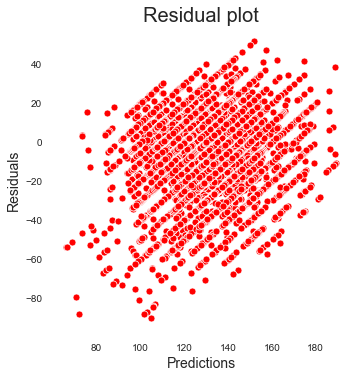

In [26]:
import seaborn as sns

rezdf = df_1
rezdf['preds'] = mlr_preds
rezdf['resids'] = (rezdf['preds'] - rezdf['ap_hi'])

# residual plot
fig = plt.figure(figsize = (12, 8))
sns.relplot(x='preds', y='resids', data=rezdf, color='red')
plt.title('Residual plot', size=20)
plt.xlabel('Predictions', size=14)
plt.ylabel('Residuals', size=14);

The code below runs the linear regression model with *ap_lo* excluded. This is what we are mainly interested in for comparison to the random forest model.

In [27]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Regression Model
mlr2 = linear_model.LinearRegression().fit(X_r2, Y_r)
# score the regression model based on Root Mean Squared Error
mlr2_preds = cross_val_predict(mlr, X_r2, Y_r, cv=cv)
mlr2_scores = cross_val_score(mlr, X_r2, Y_r, scoring='neg_root_mean_squared_error', cv=cv)
print('Average of RMSE for 10 folds (ap_lo excluded): ', np.mean(mlr2_scores))
print('Standard Deviation of RMSE for 10 folds(ap_lo excluded): ', np.std(mlr2_scores))

Average of RMSE for 10 folds (ap_lo excluded):  -14.435789746000697
Standard Deviation of RMSE for 10 folds(ap_lo excluded):  0.0949283348979379


The model performs notably worse without ap_lo, as expected, but the RMSE above is what we will use to judge a random forest model.

The code below shows us the intercept and variable coefficients for the linear regression model. If we were invested in using an MLR model we would want to check the p-values of the coefficents to determine if they are significant predictors. But we are mainly interested in getting a baseline to see how much we can reduce the RMSE by using a random forest model and unfortunately Scikit Learn does not provide an easy way to obtain the p-values.

In [28]:
# intercept and regression model coefficients
coef2 = mlr2.coef_[0].tolist()
coefdf2 = pd.DataFrame(X_r2.columns, columns=['Variable'])
coefdf2['Coefficient'] = coef2

print('Intercept: \n', mlr.intercept_)
coefdf2

Intercept: 
 [17.95366713]


,Variable,Coefficient
0,cardio,11.915905
1,weight,0.180293
2,BMI,0.092191
3,age_years,0.256457
4,cholesterol_3,2.395495


Again we need to check the residuals of the model predictions to make sure they appear as a random cloud without any significant outliers. The plot below shows that the residuals are fairly normally distributed such that the assumption is not clearly violated.

<Figure size 864x576 with 0 Axes>

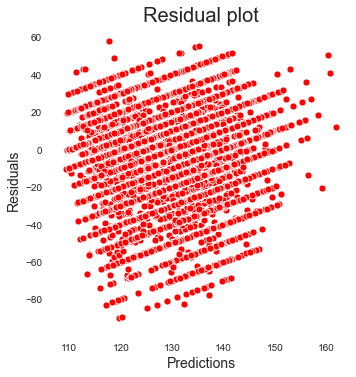

In [29]:
rezdf2 = df_1
rezdf2['preds'] = mlr2_preds
rezdf2['resids'] = (rezdf2['preds'] - rezdf2['ap_hi'])

# residual plot
fig = plt.figure(figsize = (12, 8))
sns.relplot(x='preds', y='resids', data=rezdf, color='red')
plt.title('Residual plot', size=20)
plt.xlabel('Predictions', size=14)
plt.ylabel('Residuals', size=14);

#### Predict *ap_hi* (Systolic Blood Pressure): Random Forest Regression

The code below formulates the Grid search for the best parameters for a Random Forest Regression model specifying the *max_depth* and *n_estimators* of the model. We'll take the model with the lowest mean RMSE of the cross-validated runs as the best. We will first use the same highest correlated variables from the linear regression analysis (excluding *ap_lo*).

<u>GridSearch Parameters:</u>

n_estimators = number of trees in the forest

max_depth = max number of levels in each decision tree

In [30]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#Random Forest Regression
rfr = RandomForestRegressor()

# define models and parameters
max_depth_rfr = [2,5,10,50,100] 
n_estimators_rfr = [10, 100, 1000]  

# define grid search
grid = dict(max_depth=max_depth_rfr, n_estimators=n_estimators_rfr)
grid_search = GridSearchCV(estimator=rfr, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')

In [31]:
%%time
grid_result_rfr = grid_search.fit(X_r2, Y_r)
# summarize results
print("Best: %f using %s" % (grid_result_rfr.best_score_, grid_result_rfr.best_params_))
means = grid_result_rfr.cv_results_['mean_test_score']
stds = grid_result_rfr.cv_results_['std_test_score']
params = grid_result_rfr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -14.394883 using {'max_depth': 5, 'n_estimators': 1000}
-14.629911 (0.093880) with: {'max_depth': 2, 'n_estimators': 10}
-14.628212 (0.093584) with: {'max_depth': 2, 'n_estimators': 100}
-14.624916 (0.092538) with: {'max_depth': 2, 'n_estimators': 1000}
-14.397010 (0.104983) with: {'max_depth': 5, 'n_estimators': 10}
-14.394907 (0.103868) with: {'max_depth': 5, 'n_estimators': 100}
-14.394883 (0.105519) with: {'max_depth': 5, 'n_estimators': 1000}
-14.473011 (0.098797) with: {'max_depth': 10, 'n_estimators': 10}
-14.437538 (0.104234) with: {'max_depth': 10, 'n_estimators': 100}
-14.435122 (0.103546) with: {'max_depth': 10, 'n_estimators': 1000}
-15.110323 (0.142667) with: {'max_depth': 50, 'n_estimators': 10}
-15.036484 (0.133847) with: {'max_depth': 50, 'n_estimators': 100}
-15.029730 (0.135583) with: {'max_depth': 50, 'n_estimators': 1000}
-15.112958 (0.145073) with: {'max_depth': 100, 'n_estimators': 10}
-15.037216 (0.137090) with: {'max_depth': 100, 'n_estimators': 100}
-15.0

In [32]:
print('Best mean RMSE from Grid Search: {:.3f}'.format(grid_result_rfr.best_score_))

Best mean RMSE from Grid Search: -14.395


The random forest regression model improved on the linear regression model marginally if at all. We can try adding more attributes (except *ap_lo*) for the random forest regression model to see if it can be improved. We got a general idea of the best parameters from the previous run so we can cut down some of the iterations of the grid search for this one.

In [33]:
%%time

#Random Forest Regression
rfr2 = RandomForestRegressor()

# define models and parameters
max_depth_rfr2 = [2,5,10] 
n_estimators_rfr2 = [100, 1000]

# define grid search
grid2 = dict(max_depth=max_depth_rfr2, n_estimators=n_estimators_rfr2)
grid_search2 = GridSearchCV(estimator=rfr2, param_grid=grid2, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')

X_r3 = df_1[['cardio', 'weight', 'BMI', 'age_years', 'cholesterol_3', 'cholesterol_2', 'gluc_2', 'gluc_3', 'smoke', 'alco','is_male']]
grid_result_rfr2 = grid_search2.fit(X_r3, Y_r)
# summarize results
print("Best: %f using %s" % (grid_result_rfr2.best_score_, grid_result_rfr2.best_params_))
means2 = grid_result_rfr2.cv_results_['mean_test_score']
stds2 = grid_result_rfr2.cv_results_['std_test_score']
params2 = grid_result_rfr2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -14.346599 using {'max_depth': 10, 'n_estimators': 1000}
-14.626667 (0.090686) with: {'max_depth': 2, 'n_estimators': 100}
-14.625209 (0.093335) with: {'max_depth': 2, 'n_estimators': 1000}
-14.349640 (0.105191) with: {'max_depth': 5, 'n_estimators': 100}
-14.348912 (0.102971) with: {'max_depth': 5, 'n_estimators': 1000}
-14.353302 (0.097331) with: {'max_depth': 10, 'n_estimators': 100}
-14.346599 (0.096080) with: {'max_depth': 10, 'n_estimators': 1000}
Wall time: 11min


In [34]:
print('Best mean RMSE from Grid Search: {:.3f}'.format(grid_result_rfr2.best_score_))

Best mean RMSE from Grid Search: -14.347


We were able to get a slightly smaller RMSE by including almost all of the variables but there still doesn't appear to be a large improvement.

### Analyze Results

**• [10 points] Analyze the results using your chosen method of evaluation. Use
visualizations of the results to bolster the analysis. Explain any visuals and analyze why
they are interesting to someone that might use this model.**

#### Classifying *cardio* (Cardiovascular Disease Diagnosis)

The table below shows a summary of the performance of 3 tested models based on the metrics outlined in the "Modeling and Evaluation" section:

|Model   |AUC   |Accuracy(%)   |Precision(%)   |Recall(%)  |
|:---------|:--------------|:---------------|:---------------|:---------------|
| KNN | 0.83 | 72.2 | 73.3 | 68.9|
| Random Forest | 0.85 | 73.4 | 75.5 | 68.4 | 
| SVM | 0.79 | 72.8 | 75.4 | 66.8 |

The Random Forest model had the highest accuracy and precision, while the KNN had the highest recall, and the SVM model somewhat balanced these metrics somewhere between the KNN and Random Forest models. The Random Forest model also had the highest AUC, which will be shown in plots below. We discuss the implications of these results in the "Advantages of Each Model" section.

#### Learning Curves for Classifiers

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

In [35]:
from yellowbrick.model_selection import LearningCurve

def Learning_curve_plot(model):
    # Create the learning curve visualizer
    sizes = np.linspace(0.3, 1.0, 10)
    
    visualizer = LearningCurve(
    model, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=-1)

    visualizer.fit(scaled_X, y)        # Fit the data to the visualizer
    visualizer.show()           # Finalize and render the figure

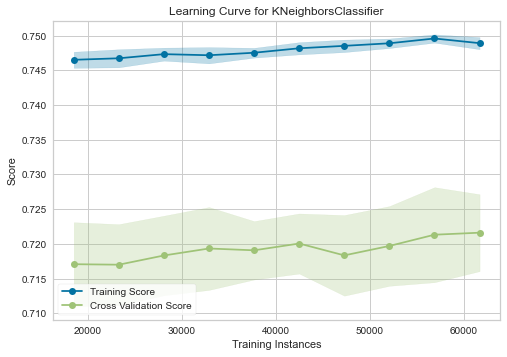

In [36]:
# Learning curve for KNN classifier
Learning_curve_plot(best_Estimator_KNN)

With KNN classifier, the training score and the validation score may not converge. KNN classifier might not benefit with more training data. With increasing training data, the validation score standard deviation also increasing which suggests the model will overfit with more data.

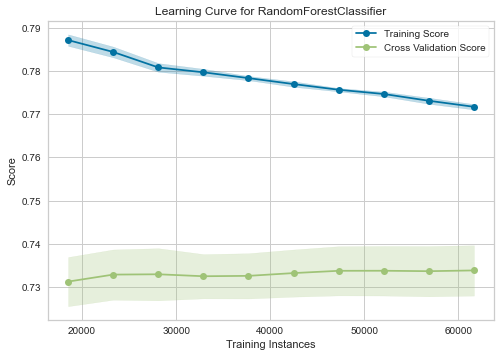

In [37]:
# Learning curve for Random Forest classifier
Learning_curve_plot(best_Estimator_RF)

With Random Forest classifier, the training score and the validation score may converge. With increasing training data, the validation score standard deviation is also not changing which suggests Random forest classifier might benefit with more training data.

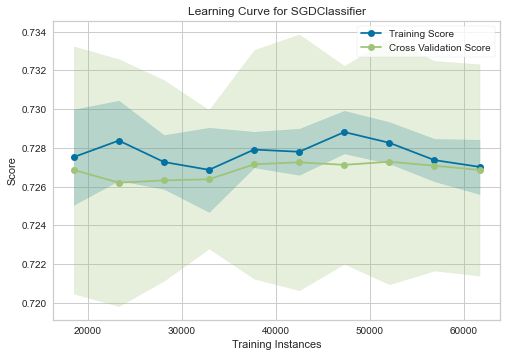

In [38]:
# Learning curve for SVM (SGD) classifier
Learning_curve_plot(best_Estimator_SVM)

With SVM (SGD) classifier, the training score and the validation score converge at low training data. SVM classifier is not learning with more data. The validation score standard deviation very big which suggests the model is overfitting the data.


#### ROC Plot for Classifiers 

The ROC curve shows the relationship between the model's ability to correctly vs incorrectly classify a patient has cardio or not. We could potentially make adjustments that could shift the ROC curve to have a higher true positive rate at the expense of increasing the false positive rate.

The ROC curve for the random forest model showed a mean area under the curve AUC of 0.85, for SVM (SGD) classifier showed a mean AUC of 0.79 and for KNN classifier showed an AUC of 0.83. From our analyses above we concluded that random forest performed the best and the ROC curve showed that as well but all 3 models had a very similar score.

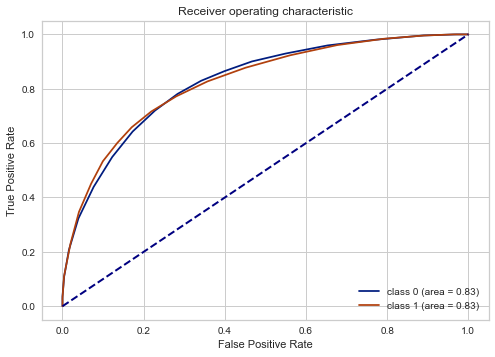

In [39]:
# ROC curve for KNN Classifier
roc_curve_plot(grid_result_KNN, scaled_X, y)

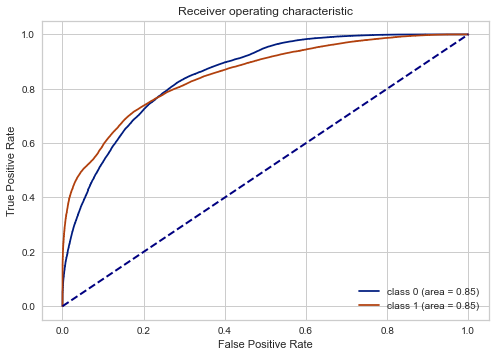

In [40]:
# ROC curve for Random Forest Classifier
roc_curve_plot(grid_result_RF, scaled_X, y)

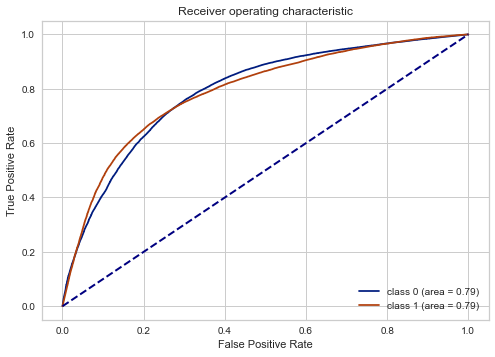

In [41]:
# ROC curve for SVM (SGD) Classifier
roc_curve_plot(grid_result_SVM, scaled_X, y)

### Advantages of Each Model

**• [10 points] Discuss the advantages of each model for each classification task, if any. If
there are not advantages, explain why. Is any model better than another? Is the
difference significant with 95% confidence? Use proper statistical comparison methods.**

#### Model Advantages - Classifying *cardio* (Cardiovascular Disease Diagnosis)

#### KNN Classifier

Advantages
 - The algorithm is simple and easy to implement.
 - There’s no need to build a model, tune several parameters, or make additional assumptions.
 - The algorithm is versatile. It can be used for classification, regression, and search (as we will see in the next section).

Disadvantages
 - The algorithm gets significantly slower as the number of examples and/or predictors/independent variables increase.

#### Random Forest Classifier

Advantages:

 - It is one of the most accurate learning algorithms available. For many data sets, it produces a highly accurate classifier.
 - It runs efficiently on large databases.
 - It can handle thousands of input variables without variable deletion.
 - It gives estimates of what variables that are important in the classification.
 - It generates an internal unbiased estimate of the generalization error as the forest building progresses.
 - It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
 
Disadvantages:
 - Random forests have been observed to overfit for some datasets with noisy classification/regression tasks.
 - For data including categorical variables with different number of levels, random forests are biased in favor of those  - attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data.

#### SVM (SGD) Classifier

Advantages:
 - SVM works relatively well when there is a clear margin of separation between classes.
 - SVM is more effective in high dimensional spaces.
 - SVM is effective in cases where the number of dimensions is greater than the number of samples.
 - SVM is relatively memory efficient

Disadvantages:
 - SVM algorithm is not suitable for large data sets.
 - SVM does not perform very well when the data set has more noise i.e. target classes are overlapping.
 - In cases where the number of features for each data point exceeds the number of training data samples, the SVM will underperform.
 - As the support vector classifier works by putting data points, above and below the classifying hyperplane there is no probabilistic explanation for the classification.

#### Statistical Comparison

In [42]:
from sklearn.model_selection import cross_val_score

acc_KNN = cross_val_score(best_Estimator_KNN, scaled_X, y=y, cv=cv)
acc_RF = cross_val_score(best_Estimator_RF, scaled_X, y=y, cv=cv)
acc_SVM = cross_val_score(best_Estimator_SVM, scaled_X, y=y, cv=cv)

In [43]:
t = 2.26 / np.sqrt(10)

e_SVM_KNN = (1-acc_SVM)-(1-acc_KNN)
e_SVM_RF = (1-acc_SVM)-(1-acc_RF)
e_KNN_RF = (1-acc_KNN)-(1-acc_RF)

stdtot_S_K = np.std(e_SVM_KNN)
stdtot_S_R = np.std(e_SVM_RF)
stdtot_K_R = np.std(e_KNN_RF)

dbarSK = np.mean(e_SVM_KNN)
dbarSR = np.mean(e_SVM_RF)
dbarKR = np.mean(e_KNN_RF)

print ('Range of SVM_KNN confidence interval : [%0.6f,  %0.6f]' % (dbarSK-t*stdtot_S_K,dbarSK+t*stdtot_S_K))
print ('Range of SVM_RF confidence interval  : [%0.6f,  %0.6f]' % (dbarSR-t*stdtot_S_R,dbarSR+t*stdtot_S_R))
print ('Range of KNN_RF confidence interval  : [%0.6f,  %0.6f]' % (dbarKR-t*stdtot_K_R,dbarKR+t*stdtot_K_R))


Range of SVM_KNN confidence interval : [-0.008767,  -0.003842]
Range of SVM_RF confidence interval  : [0.003683,  0.009101]
Range of KNN_RF confidence interval  : [0.010663,  0.014730]


According to above confidence interval range for each two models comparison, none of them contain contain 0. So, we are 95% confident that KNN classifier, Random forest classifier and SVM (SGD) classifier models  are not same. With 10 fold cross validation, one of the assumption of independent observations for the t-test is voilated, lets validate the statistical significance of the models with 5 X 2 cross validation  

#### 5x2cv paired t-test

The 5x2cv paired t test is a procedure for comparing the performance of two models (classifiers or regressors) that was proposed by Dietterich to address shortcomings in other methods such as the resampled paired t test and the k-fold cross-validated paired t test

#### 5X2, paired t-test between KNN classifier and Random Forest classifier Models 

In [44]:

from mlxtend.evaluate import paired_ttest_5x2cv
t, p = paired_ttest_5x2cv(estimator1=best_Estimator_KNN,
                          estimator2=best_Estimator_RF,
                          X=scaled_X, y=y,
                          random_seed=1234)

In [45]:
print('T value:',t, 'P-value', p)

T value: -6.767458351821843 P-value 0.0010705044136934884


 - With a P-value of 0.001 and a T value of -6.76, we reject null hypothesis (null hypothesis that the learning algoritms have the same error rate on a given dataset). We can conclude that there is a statistically significant difference in error rate between KNN classifier and Random Forest classifier

#### 5X2, paired t-test between KNN classifier and SVM (SGD) classifier Models 

In [46]:
from mlxtend.evaluate import paired_ttest_5x2cv
t, p = paired_ttest_5x2cv(estimator1=best_Estimator_KNN,
                          estimator2=best_Estimator_SVM,
                          X=scaled_X, y=y,
                          random_seed=1234)

In [47]:
print('T value:',t, 'P-value', p)

T value: -2.2121315637164476 P-value 0.07789529262494929


 - With a P-value of 0.077 and a T value of -2.212, we fail to reject null hypothesis (null hypothesis that the learning algoritms have the same error rate on a given dataset). We can conclude that there both KNN classifier and SVM (SGD) classifiers have same error rate.

#### 5X2, paired t-test between Random Forest classifier and SVM (SGD) classifier Models 

In [48]:
from mlxtend.evaluate import paired_ttest_5x2cv
t, p = paired_ttest_5x2cv(estimator1=best_Estimator_RF,
                          estimator2=best_Estimator_SVM,
                          X=scaled_X, y=y,
                          random_seed=1234)

In [49]:
print('T value:',t, 'P-value', p)

T value: 7.253558054183993 P-value 0.0007779296325653931


With a P-value of 0.0007 and a T value of 7.253, we reject null hypothesis (null hypothesis that the learning algoritms have the same error rate on a given dataset). We can conclude that there is a statistically significant difference in error rate between SVM (SGD) classifier and Random Forest classifier

#### Model Advantages -  - Predicting *ap_hi* (Systolic Blood Pressure)

For predicting systolic blood pressure (while ommiting diastolic pressure as it makes little practical sense to include it), there was little visible advantage to using more complicated and/or computationally intensive models than linear methods for prediction. The RMSE only improved slightly with the Random Forest Regression model and the addition of less important features. This could be because the most important feature by far was a binary categorical attribute - *cardio*, and categorical features are not going to be very deterministic of a contiuous variable. 

### Identify Important Attributes

**• [10 points] Which attributes from your analysis are most important? Use proper
methods discussed in class to evaluate the importance of different attributes. Discuss
the results and hypothesize about why certain attributes are more important than others
for a given classification task.**

#### Feature Importance - Predicting *cardio* (Cardiovascular Disease Diagnosis) with Random Forest Classifier

We can view the most important features in the top performing Random  forest classifier by viewing the coefficents for the weights of each variable in predicting *cardio*. Feature importance below was performed for the model created using the model with hyperparameters tuned by the grid search.

In [50]:
# Important features with their weights 
features = df_onehot.columns

imp_feature_df = pd.DataFrame({'feature_names':df_onehot.columns, 
                               'Coef_weights':Coef_weights_RF})
imp_feature_df.sort_values(by='Coef_weights', inplace=True, ascending=False )

imp_feature_df

,feature_names,Coef_weights
2,ap_hi,0.393627
3,ap_lo,0.170816
7,age_years,0.133148
11,cholesterol_3,0.066210
1,weight,0.062721
8,BMI,0.062106
0,height,0.053917
10,cholesterol_2,0.012117
6,active,0.010959
13,gluc_3,0.008982


Text(0, 0.5, 'Feature Names')

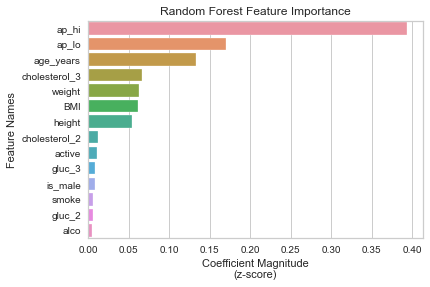

In [51]:
# Visulization of important features 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax = sns.barplot(x ='Coef_weights', y = 'feature_names',data=imp_feature_df, orient= 'h')
ax.set_title("Random Forest Feature Importance")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

 - Random Forest feature importance display shows the top 5 most important features. For random forest, the top 5 features are ap_hi, ap_lo, age_years, Cholesterol_3 and weight. *ap_hi* has three times the coefficient magnitude by z-score as the next non-blood pressure realted variable (age). 


 - The high positive influence of systolic blood pressure on positive diagnosis is consistent with what we found in visualizing this data in Lab 1, and the top weight demonstrates that this is by far the most important variable in the prediction. All of the variables that appeared as positive influences on a positive diagnosis are amoung the common contributors to heart disease outlined by the American Heart Association, so we don't see anything unexpected here.

#### Feature Importance using Recursive Feature Elimination - Predicting *cardio* (Cardiovascular Disease Diagnosis)

In [52]:
# recursive Feature elimination to identify important features
from sklearn.feature_selection import RFECV

# Instance of Recursive Feature Elimination
rfecv = RFECV(estimator=best_Estimator_RF, step=1, cv=cv, n_jobs=-1, scoring='accuracy')

# Fit RFE
rfecv.fit(scaled_X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=15, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=10,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=300, n_jobs=None,
                                       oob_score=False, random_state=1234,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
      verbose=0)

In [53]:
# get column names
columns = pd.DataFrame(list(df_onehot.columns))

# Get the ranking of features
ranking = pd.DataFrame(rfecv.ranking_)

# ranking and their importance
rfe_selected = pd.DataFrame()
rfe_selected  = pd.concat([columns, ranking], axis=1)
rfe_selected.columns = ['Feature Name', 'Ranking']
rfe_selected_sorted = rfe_selected.sort_values(by=['Ranking'], ascending=True)
print(rfe_selected_sorted)

     Feature Name  Ranking
0          height        1
1          weight        1
2           ap_hi        1
3           ap_lo        1
4           smoke        1
6          active        1
7       age_years        1
8             BMI        1
9         is_male        1
10  cholesterol_2        1
11  cholesterol_3        1
12         gluc_2        1
13         gluc_3        1
5            alco        2


Recursive feature elimination suggested to include all features except "alcohol" feature. This echoes the feature importance by z-score of the Random Forest model which shows *alco* as that of lowest importance. This is an interesting discovery as alcohol is often mentioned by many as a contributor to heart disease, yet it shows no effects here. It is possible that there is a collection bias as discussed in Lab 1, or perhaps the measure that represents a '1' in the binary response is not severe enough.

#### Important Features - Predicting *ap_hi* (Systolic Blood Pressure): Random Forest Regression

In [54]:
#running RF with best parameters
rfr_f = RandomForestRegressor(max_depth=5, n_estimators=1000)
rfr_f.fit(X_r3, Y_r)
rfr_f_scores = cross_val_score(rfr_f, X_r3, Y_r, scoring='neg_root_mean_squared_error', cv=cv)
rfr_f_preds = cross_val_predict(rfr_f, X_r3, Y_r, cv=cv)

Random Forest Regression with sklearn has a feature importance function that returns the feature importances of each included variable.

In [55]:
rfr_imp = rfr_f.feature_importances_
rfr_imp_df = pd.DataFrame({'Feature Importance': rfr_imp}, index=X_r3.columns)
rfr_imp_df

,Feature Importance
cardio,0.747778
weight,0.090712
BMI,0.065385
age_years,0.051303
cholesterol_3,0.024354
cholesterol_2,0.014672
gluc_2,0.001211
gluc_3,0.000263
smoke,0.001892
alco,0.000985


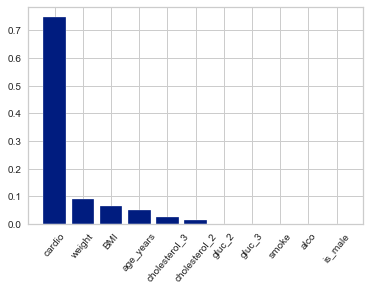

In [56]:
# plot feature importance
from matplotlib import pyplot
pyplot.bar(X_r3.columns, rfr_imp)
pyplot.xticks(rotation=50)
pyplot.show()

Interestingly, the binary feature *cardio* that is our target class in the classification models is by far the highest predictor in the Random forest regression model. It is not surprising as the *ap_hi* feature is the most influential for classifying *cardio* and the reverse would make sense to be true, but it is unfortunate as we can't get much preditive power for a continuous class out of a binary predictor.

## Deployment

**• [5 points] How useful is your model for interested parties (i.e., the companies or
organizations that might want to use it for prediction)? How would you measure the
model's value if it was used by these parties? How would your deploy your model for
interested parties? What other data should be collected? How often would the model
need to be updated, etc.?**

The data we have is being used to predict cardiovascular disease. Clearly, an accurate model for predicting disease early can save lives if it means effective treatments and/or interventions can be deployed sooner. 

The utility of a reliable model is in a form of risk identification. If our model flags a patient as being at risk, despite having no expressed symptoms, a clinician may use it to begin a more focused analysis on the patient. Thus, this is a tool for prescreening.

Since this model would most likely be an early warning tool, a high rate of false positives is more acceptable. 

## Exceptional Work

**• You have free reign to provide additional modeling.**
**• One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a
good model for each classification algorithm?**

We used grid searches to tune the hyperparameters for all of our classification models; these are shown in the "Creation of 3 Different Models" Section. we would like to examine each parameter's performance used in grid search with visualization and identify which are most significant parameters in predicting cardio. we chose validation curves to visualize each parameters performance in classification models

#### Validation Curves

A Validation Curve is an important diagnostic tool that shows the sensitivity between to changes in a  model's accuracy with change in some parameter of the model. A validation curve is typically drawn between some parameter of the model and the model's score.

Validation Curve is also helpful in identifying the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values

#### KNN Classifier parameter Visualizations

<u> n_neighbors parameter</u>

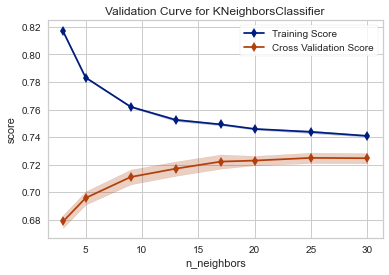

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='n_neighbors', ylabel='score'>

In [57]:
from yellowbrick.model_selection import ValidationCurve
viz = ValidationCurve(
    KNN, param_name="n_neighbors",
    param_range=[3,5,9, 13, 17, 20, 25, 30], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training score converge to a value that is quite low with increasing K value (number of neighbors). So KNN classfier can be generalized with intermediate value of K.

<u>leaf_size parameter</u>

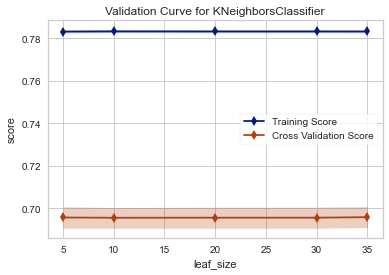

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='leaf_size', ylabel='score'>

In [58]:
viz = ValidationCurve(
    KNN, param_name="leaf_size",
    param_range=[5, 10, 20, 30, 35], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

No change in validation score and the training score with increasing leaf_size parameter. Leaf_size parameter may not be useful parameter in predicting cardio in KNN classifier.

<u>algorithm parameter</u>

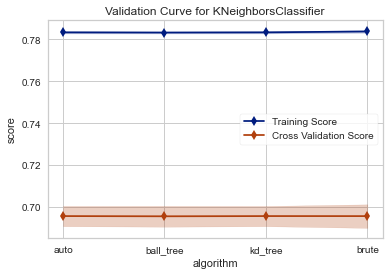

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='algorithm', ylabel='score'>

In [59]:
viz = ValidationCurve(
    KNN, param_name="algorithm",
    param_range=['auto', 'ball_tree', 'kd_tree', 'brute'], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

There is no change in the validation score and the training score for various Algorithms (which is used to compute the nearest neighbors). Algotithm parameter may not be useful parameter in predicting cardio in KNN classifier.

<u>metric parameter</U>

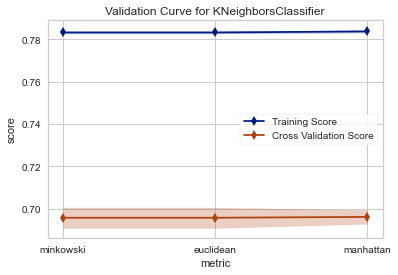

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='metric', ylabel='score'>

In [60]:
viz = ValidationCurve(
    KNN, param_name="metric",
    param_range=['minkowski','euclidean', 'manhattan'], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

There is no change in the validation score and the training score for various values of metric parameter. Metric parameter may not be useful parameter in predicting cardio in KNN classifier.

<u>weights parameter</u>

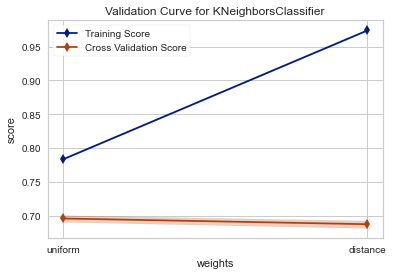

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='weights', ylabel='score'>

In [61]:
viz = ValidationCurve(
    KNN, param_name="weights",
    param_range=['uniform','distance'], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

The validation score and the training score is ok with "uniform" weight parameter, but there is big difference between validation score and training score with "distance" weight parameter, which is overfit condition. We need to go with "uniform" weight parameter in predicting the cardio.

<b>n_neighbors and weights parameters are most significant parameters in predicting cardio with KNN classifier</b>

#### Random Forest Classifier parameter Visualizations

<u>n_estimators parameter</u>

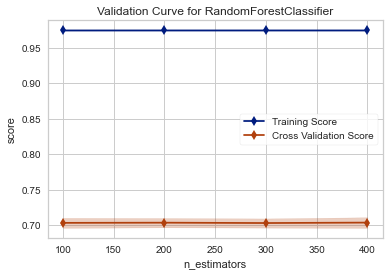

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [62]:
viz = ValidationCurve(
    RF, param_name="n_estimators",
    param_range=[100, 200, 300, 400], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

There is no change in the validation score and the training score as number of trees increased in the forest parameter. n_estimators parameter may not be useful parameter in predicting cardio in random forest classifier.

<u>max_depth parameter</u>

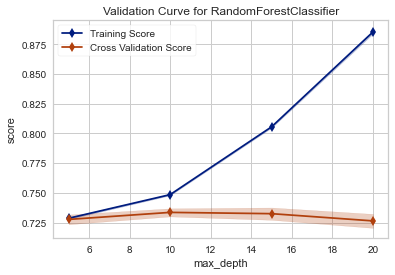

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [63]:
viz = ValidationCurve(
    RF, param_name="max_depth",
    param_range=[5, 10, 15, 20], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

The validation score and the training score is ok with low values of max_depth parameter, but there is huge difference between validation score and training score with increasing values of max_depth parameter, which is overfit condition. We need to go with lower values of max-depth parameter for best model in predicting the cardio.

<u>min_samples_leaf parameter</u>

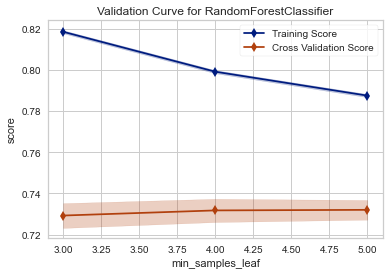

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='min_samples_leaf', ylabel='score'>

In [64]:
viz = ValidationCurve(
    RF, param_name="min_samples_leaf",
    param_range=[3, 4, 5], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training score converge to a value that is quite low accuracy with increasing min_samples_leaf (The minimum number of samples required to be at a leaf node). So Random Forest classfier can be generalized with intermediate value of min_samples_leaf parameter.

<u>min_samples_split parameter</u>

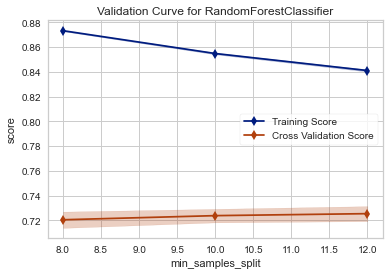

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='min_samples_split', ylabel='score'>

In [65]:
viz = ValidationCurve(
    RF, param_name="min_samples_split",
    param_range=[8, 10, 12], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training score converge to a value that is quite low accuracy with increasing min_samples_split (The minimum number of samples required to split an internal node). So Random forest classfier can be generalized with intermediate value of min_samples_leaf parameter.

<b>max_depth, min_samples_leaf and min_samples_split parameters are most significant parameters in predicting cardio with Random Forest classifier</b>

#### SVM Classifier parameter Visualizations

<u>loss parameter</u>

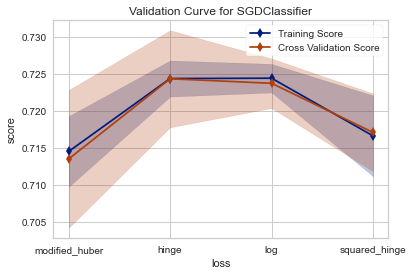

<AxesSubplot:title={'center':'Validation Curve for SGDClassifier'}, xlabel='loss', ylabel='score'>

In [66]:
viz = ValidationCurve(
    SVM, param_name="loss",
    param_range=['modified_huber', 'hinge', 'log', 'squared_hinge'], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training scores are increasing with 'modified_huber', 'hinge' and 'log' values for loss parameter and decreasing the scores with 'squared_hinge' loss parameter. 'hinge' loss parameter might be most significant in predicting cardio with SVM classifier. 

<u>alpha parameter</u>

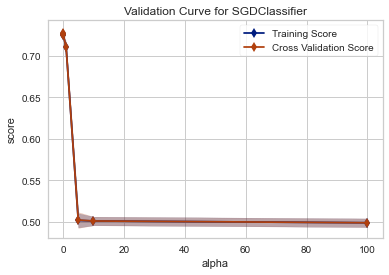

<AxesSubplot:title={'center':'Validation Curve for SGDClassifier'}, xlabel='alpha', ylabel='score'>

In [67]:
viz = ValidationCurve(
    SVM, param_name="alpha",
    param_range=[0.001, 0.01, 0.1, 1, 5, 10, 100], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training scores are desceasing with increasing values for alpha parameter. Low values of alpha parameter might be most significant in predicting cardio with SVM classifier. 

<u>max_iter parameter</u>

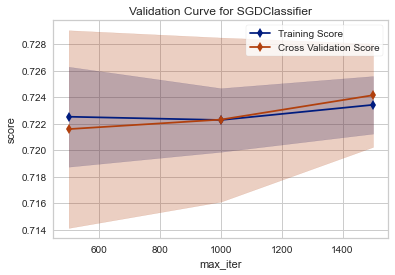

<AxesSubplot:title={'center':'Validation Curve for SGDClassifier'}, xlabel='max_iter', ylabel='score'>

In [68]:
viz = ValidationCurve(
    SVM, param_name="max_iter",
    param_range=[500, 1000, 1500], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training scores are inceasing with increasing values for max_iter parameter upto 1000 and converges at 1000, then validation score is more than training score. Value less than 100 for max_iter parameter might be most significant in predicting cardio with SVM classifier. 

<b>loss, alpha and max-iter parameters are most significant parameters in predicting cardio with SVM classifier</b>

### Additional Models

#### Decision Trees

In [69]:
from sklearn.tree import DecisionTreeClassifier

# define parameters
max_depth_DT = [1, 5,10, 15, 20, 25, 30, 32]
min_samples_split_DT = [0.1, 1, 10]
max_features_DT = list(range(1, scaled_X.shape[1]))
random_state_DT = [1234]

# define grid search
param_grid_DT = dict(max_depth=max_depth_DT, min_samples_split=min_samples_split_DT,
                     max_features=max_features_DT, random_state=random_state_DT)

DT = DecisionTreeClassifier()

grid_search_DT = GridSearchCV(estimator=DT, param_grid=param_grid_DT, n_jobs=-1, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [70]:
%%time
grid_result_DT = grid_search_DT.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_DT.best_score_, grid_result_DT.best_params_))
means = grid_result_DT.cv_results_['mean_test_score']
stds = grid_result_DT.cv_results_['std_test_score']
params = grid_result_DT.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 312 candidates, totalling 3120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1970 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:  1.2min


Best: 0.730222 using {'max_depth': 5, 'max_features': 13, 'min_samples_split': 10, 'random_state': 1234}
0.518074 (0.004874) with: {'max_depth': 1, 'max_features': 1, 'min_samples_split': 0.1, 'random_state': 1234}
0.000000 (0.000000) with: {'max_depth': 1, 'max_features': 1, 'min_samples_split': 1, 'random_state': 1234}
0.518074 (0.004874) with: {'max_depth': 1, 'max_features': 1, 'min_samples_split': 10, 'random_state': 1234}
0.518074 (0.004874) with: {'max_depth': 1, 'max_features': 2, 'min_samples_split': 0.1, 'random_state': 1234}
0.000000 (0.000000) with: {'max_depth': 1, 'max_features': 2, 'min_samples_split': 1, 'random_state': 1234}
0.518074 (0.004874) with: {'max_depth': 1, 'max_features': 2, 'min_samples_split': 10, 'random_state': 1234}
0.573311 (0.006126) with: {'max_depth': 1, 'max_features': 3, 'min_samples_split': 0.1, 'random_state': 1234}
0.000000 (0.000000) with: {'max_depth': 1, 'max_features': 3, 'min_samples_split': 1, 'random_state': 1234}
0.573311 (0.006126) wit

[Parallel(n_jobs=-1)]: Done 3120 out of 3120 | elapsed:  1.6min finished


In [71]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_DT =grid_result_DT.best_estimator_
best_Estimator_DT

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=13, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

In [72]:
# Display model metrics
displayModel_metrics(best_Estimator_DT, grid_result_DT, scaled_X, y, cv)

Fold Scores:
 
[0.73019116 0.73121261 0.72989931 0.73861646 0.72081144 0.72548161
 0.73277875 0.7267951  0.72942207 0.73701109]
 
Best Accuracy   :  0.730
Mean Accuracy   :  0.7302219599667404
Mean Precision  :  0.7475747363382776
Mean Recall     :  0.6865781710914454
Mean Fit Time   :  0.3643163204193115
Mean Score Time :  0.014892101287841797
CV Time         :  0.6733965873718262


With Decision tree classifier achieving an accuracy of 73% which is better than KNN classifier and SVM classifier. But the accuracy is less than Random forest classifier

#### Naive Bayes

In [73]:
from sklearn.naive_bayes import GaussianNB

var_smoothing_GNB = [1e-15, 1e-09, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1, 10, 100]

# define grid search
param_grid_GNB = dict(var_smoothing=var_smoothing_GNB)

GNB = GaussianNB()

grid_search_GNB = GridSearchCV(estimator=GNB, param_grid=param_grid_GNB, n_jobs=-1, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [74]:
%%time
grid_result_GNB = grid_search_GNB.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_GNB.best_score_, grid_result_GNB.best_params_))
means = grid_result_GNB.cv_results_['mean_test_score']
stds = grid_result_GNB.cv_results_['std_test_score']
params = grid_result_GNB.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s


Best: 0.692599 using {'var_smoothing': 1e-15}
0.692599 (0.006505) with: {'var_smoothing': 1e-15}
0.692599 (0.006505) with: {'var_smoothing': 1e-09}
0.692599 (0.006505) with: {'var_smoothing': 1e-08}
0.692599 (0.006505) with: {'var_smoothing': 1e-07}
0.692599 (0.006505) with: {'var_smoothing': 1e-06}
0.692599 (0.006505) with: {'var_smoothing': 1e-05}
0.692599 (0.006505) with: {'var_smoothing': 0.0001}
0.679421 (0.006248) with: {'var_smoothing': 1}
0.638968 (0.005157) with: {'var_smoothing': 10}
0.537425 (0.002384) with: {'var_smoothing': 100}
Wall time: 2.13 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


In [75]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_GNB =grid_result_GNB.best_estimator_
best_Estimator_GNB

GaussianNB(priors=None, var_smoothing=1e-15)

In [76]:
# Display model metrics
displayModel_metrics(best_Estimator_GNB, grid_result_GNB, scaled_X, y, cv)

Fold Scores:
 
[0.69867211 0.69239749 0.69677513 0.69658494 0.6770286  0.68797431
 0.69483363 0.68666083 0.69775248 0.69731465]
 
Best Accuracy   :  0.693
Mean Accuracy   :  0.6925994184947528
Mean Precision  :  0.7390342595338927
Mean Recall     :  0.5853982300884957
Mean Fit Time   :  0.1255547046661377
Mean Score Time :  0.01968991756439209
CV Time         :  0.339324951171875


With GaussianNB classifier achieving an accuracy of 69.2% which is least among all classifier models we tested.

### References

 - https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb


 - https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html


 - https://scikit-learn.org/stable/modules/learning_curve.html
